In [1]:
!pip install xgboost

In [2]:
import numpy as np

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

**Model Configuration**

In [22]:
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        C=1.0,
        max_iter=1000,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='logloss',
        random_state=42
    )
}

In [5]:
# Load individual statistics files
aces_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Aces_Per_Set_Team_2024.csv")
attacks_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Team_Attacks_Per_Set_Team_2024.csv")
blocks_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Blocks_Per_Set_Team_2024.csv")
assists_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Assists_Per_Set_Team_2024.csv")
digs_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Digs_Per_Set_Team_2024.csv")
kills_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Kills_Per_Set_Team_2024.csv")
wins_df = pd.read_csv("/Users/jamerafernando/Documents/GitHub/wi25-ai-team1/allStatCSVS/Match_W-L_Pctg._Team_2024.csv")

# Display first few rows of each dataset to verify loading
print("Aces Data:")
display(aces_df.head())
print("\nAttacks Data:")
display(attacks_df.head())
print("\nBlocks Data:")
display(blocks_df.head())
print("\Wins Data:")
display(wins_df.head())

Aces Data:


,Rank,Team,S,W-L,Aces,Per Set
0,1,Saint Francis (PA) (NEC),113,21-9,237,2.10
1,2,Hawaii (Big West),106,23-7,215,2.03
2,3,Fort Valley St. (SIAC),81,17-9,157,1.94
3,4,UCLA (MPSF),118,26-5,224,1.90
4,5,Princeton (EIVA),92,12-12,167,1.82



Attacks Data:


,Rank,Team,S,W-L,Kills,Errors,Total Attacks,Per Set
0,1,McKendree (MIVA),94,14-12,"1,183",402,"2,748",29.23
1,2,North Greenville (Conference Carolinas),94,15-9,"1,141",450,"2,668",28.38
2,3,Barton (Conference Carolinas),92,12-13,941,456,"2,601",28.27
3,4,Lindenwood (MIVA),102,16-12,"1,325",436,"2,883",28.26
4,5,UC Irvine (Big West),117,20-11,"1,549",472,"3,306",28.26



Blocks Data:


,Rank,Team,S,W-L,Block Solos,Block Assists,TB,Per Set
0,1,Long Beach St. (Big West),107,27-3,52,566,335.0,3.131
1,2,Mount Olive (Conference Carolinas),96,17-10,76,338,245.0,2.552
2,3,LIU (NEC),96,14-13,62,365,244.5,2.547
3,4,UCLA (MPSF),118,26-5,37,520,297.0,2.517
4,5,Barton (Conference Carolinas),92,12-13,81,300,231.0,2.511


\Wins Data:


,Rank,Team,W,L,Pct.
0,1,Long Beach St. (Big West),27,3,0.900
1,2,Grand Canyon (MPSF),26,5,0.839
2,2,UCLA (MPSF),26,5,0.839
3,4,Belmont Abbey (Conference Carolinas),21,5,0.808
4,4,Lincoln Memorial (DI Independent),21,5,0.808


In [6]:
def clean_team_name(name):
    """
    Clean team names by removing conference information and standardizing common variations
    """
    # Remove conference information in parentheses
    name = name.split('(')[0].strip()
    
    # Common name variations mapping
    name_mapping = {
        'St.': 'Saint',
        'Int\'l': 'International',
        'Va.': 'Virginia',
        'Mt.': 'Mount',
        'CarolinaU': 'Carolina University',
        'CUI': 'Concordia Irvine',
        'LIU': 'Long Island University',
        'UMSV': 'UMass Lowell',
        'CSUN': 'Cal State Northridge',
        'UC': 'University of California',
        'BYU': 'Brigham Young',
        'NJIT': 'New Jersey Tech',
        'Long Beach St.': 'Long Beach State',
        'Ball St.': 'Ball State',
        'Penn St.': 'Penn State',
        'Ohio St.': 'Ohio State'
    }
    
    # Apply name standardization
    for key, value in name_mapping.items():
        if key in name:
            name = name.replace(key, value)
    
    return name.strip()

In [7]:
stats_combined = pd.DataFrame()

stats_combined['team'] = aces_df['Team'].apply(clean_team_name)
stats_combined['aces_per_set'] = aces_df['Per Set']
stats_combined['attacks_per_set'] = attacks_df['Per Set']
stats_combined['blocks_per_set'] = blocks_df['Per Set']
stats_combined['digs_per_set'] = digs_df['Per Set']
stats_combined['kills_per_set'] = kills_df['Per Set']
stats_combined['win_percentage'] = wins_df['Pct.']
stats_combined['assists_per_set'] = assists_df['Per Set']

print("Combined team statistics:")
display(stats_combined.head(30))

team_stats = stats_combined

Combined team statistics:


,team,aces_per_set,attacks_per_set,blocks_per_set,digs_per_set,kills_per_set,win_percentage,assists_per_set
0,Saint Francis,2.10,29.23,3.131,10.19,13.24,0.900,12.53
1,Hawaii,2.03,28.38,2.552,10.09,12.99,0.839,12.33
2,Fort Valley Saint,1.94,28.27,2.547,9.86,12.92,0.839,12.24
3,University of CaliforniaLA,1.90,28.26,2.517,9.77,12.90,0.808,12.04
4,Princeton,1.82,28.26,2.511,9.68,12.85,0.808,11.99
5,Dominican,1.78,28.19,2.453,9.46,12.73,0.769,11.97
6,Cal State Northridge,1.70,27.81,2.417,9.39,12.71,0.767,11.86
7,Lincoln Memorial,1.66,27.80,2.402,9.17,12.65,0.767,11.83
8,Long Beach Saint,1.65,27.68,2.362,9.15,12.65,0.724,11.71
9,Penn Saint,1.65,27.62,2.342,9.15,12.59,0.710,11.71


In [8]:
matches_df = pd.read_csv("2024MensNcaaGames.csv")
display(matches_df.head(30))

,Unnamed: 0,Team 1,Team 1 Score,Team 2,Team 2 Score
0,0,Wabash,0.0,Ball St.,3.0
1,1,Wabash,0.0,Ball St.,3.0
2,2,Thomas More,0.0,Ball St.,3.0
3,3,Wabash,1.0,Thomas More,3.0
4,4,North Greenville,0.0,Ohio St.,3.0
5,5,Fort Valley St.,0.0,Pepperdine,3.0
6,6,Loyola Chicago,0.0,Hawaii,3.0
7,7,NJIT,1.0,UC Santa Barbara,3.0
8,8,Central St. (OH),0.0,Penn St.,3.0
9,9,Grand Canyon,3.0,CSUN,0.0


**Prepare and Clean Training Data**

In [9]:
def find_team_stats(team_name, stats_df):
    """
    Find team statistics using fuzzy name matching
    """
    # Clean the input team name
    clean_name = clean_team_name(team_name)
    
    # Try to find the team in the stats DataFrame
    team_matches = stats_df[stats_df['team'].apply(clean_team_name) == clean_name]
    
    if len(team_matches) == 0:
        # Print available team names for debugging
        print(f"Available teams: {', '.join(stats_df['team'].apply(clean_team_name).unique())}")
        raise ValueError(f"Could not find stats for team: {team_name} (cleaned: {clean_name})")
    
    return team_matches.iloc[0]

def predict_match_improved(team1_name, team2_name, model_name='Random Forest'):
    """
    Predict the winner of a volleyball match using the specified model
    """
    try:
        # Get team statistics
        team1_stats = find_team_stats(team1_name, team_stats)
        team2_stats = find_team_stats(team2_name, team_stats)
        
        # Prepare feature vector
        match_feature = [
            team1_stats['aces_per_set'],
            team1_stats['attacks_per_set'],
            team1_stats['blocks_per_set'],
            team1_stats['digs_per_set'],
            team1_stats['kills_per_set'],
            team1_stats['assists_per_set'],
            team1_stats['win_percentage'],
            team2_stats['aces_per_set'],
            team2_stats['attacks_per_set'],
            team2_stats['blocks_per_set'],
            team2_stats['digs_per_set'],
            team2_stats['kills_per_set'],
            team2_stats['win_percentage'],
            team2_stats['assists_per_set']
        ]
        
        # Scale features
        X_new = scaler.transform([match_feature])
        
        # Make prediction
        model = models[model_name]
        prediction = model.predict(X_new)[0]
        
        return prediction, team1_stats, team2_stats
        
    except Exception as e:
        print(f"Error predicting match: {str(e)}")
        return None, None, None

In [10]:
# Prepare training data from matches
X = []
y = []

for _, match in matches_df.iterrows():
    team1_name = clean_team_name(match['Team 1'])
    team2_name = clean_team_name(match['Team 2'])
    
    try:
        team1_stats = find_team_stats(team1_name, team_stats)
        team2_stats = find_team_stats(team2_name, team_stats)
        
        # Create feature vector
        match_features = [
            team1_stats['aces_per_set'],
            team1_stats['attacks_per_set'],
            team1_stats['blocks_per_set'],
            team1_stats['digs_per_set'],
            team1_stats['kills_per_set'],
            team1_stats['assists_per_set'],
            team1_stats['win_percentage'],
            team2_stats['aces_per_set'],
            team2_stats['attacks_per_set'],
            team2_stats['blocks_per_set'],
            team2_stats['digs_per_set'],
            team2_stats['kills_per_set'],
            team2_stats['assists_per_set'],
            team2_stats['win_percentage']
        ]
        
        X.append(match_features)
        # 1 if team1 won, 0 if team2 won
        y.append(1 if match['Team 1 Score'] > match['Team 2 Score'] else 0)
    except ValueError as e:
        print(f"Skipping match due to missing stats: {str(e)}")
        continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Available teams: Saint Francis, Hawaii, Fort Valley Saint, University of CaliforniaLA, Princeton, Dominican, Cal State Northridge, Lincoln Memorial, Long Beach Saint, Penn Saint, Lindenwood, George Mason, Ohio Saint, Daemen, Roberts Wesleyan, Stanford, Long Island University, Mount Olive, Loyola Chicago, North Greenville, Charleston, University of California Irvine, Brigham Young, New Jersey Tech, University of California Santa Barbara, Merrimack, Grand Canyon, Kentucky Saint, Maryville, Belmont Abbey, Saint Thomas Aquinas, Queens, Missouri S&T, McKendree, Erskine, University of California San Diego, Pepperdine, Ball Saint, Lewis, Quincy, Purdue Fort Wayne, Sacred Heart, Concordia Irvine, FDU, Southern California, King, Harvard, D'Youville, Barton, Emmanuel
Skipping match due to missing stats: Could not find stats for team: Wabash (cleaned: Wabash)
Available teams: Saint Francis, Hawaii, Fort Valley Saint, University of CaliforniaLA, Princeton, Dominican, Cal State Northridge, Lincoln 

**Testing the Data**

In [24]:
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.3f}")

    # Feature importance for Random Forest and XGBoost
    if model_name in ["Random Forest", "XGBoost"]:
        feature_importance = model.feature_importances_
        features = ['Team 1 Aces/Set', 'Team 1 Attacks/Set', 'Team 1 Blocks/Set', 
                   'Team 1 Digs/Set', 'Team 1 Kills/Set', 'Team 1 Assists/Set',
                   'Team 1 Win %', 'Team 2 Aces/Set', 'Team 2 Attacks/Set', 
                   'Team 2 Blocks/Set', 'Team 2 Digs/Set', 'Team 2 Kills/Set',
                   'Team 2 Win %', 'Team 2 Assists/Set']
        
        print("\nFeature Importance:")
        for feature, importance in zip(features, feature_importance):
            print(f"{feature}: {importance:.3f}")


Random Forest Results:
Accuracy: 0.629

Feature Importance:
Team 1 Aces/Set: 0.072
Team 1 Attacks/Set: 0.074
Team 1 Blocks/Set: 0.085
Team 1 Digs/Set: 0.075
Team 1 Kills/Set: 0.071
Team 1 Assists/Set: 0.067
Team 1 Win %: 0.065
Team 2 Aces/Set: 0.066
Team 2 Attacks/Set: 0.069
Team 2 Blocks/Set: 0.082
Team 2 Digs/Set: 0.069
Team 2 Kills/Set: 0.076
Team 2 Win %: 0.067
Team 2 Assists/Set: 0.062

Logistic Regression Results:
Accuracy: 0.647

XGBoost Results:
Accuracy: 0.603

Feature Importance:
Team 1 Aces/Set: 0.142
Team 1 Attacks/Set: 0.206
Team 1 Blocks/Set: 0.203
Team 1 Digs/Set: 0.000
Team 1 Kills/Set: 0.000
Team 1 Assists/Set: 0.000
Team 1 Win %: 0.000
Team 2 Aces/Set: 0.173
Team 2 Attacks/Set: 0.140
Team 2 Blocks/Set: 0.136
Team 2 Digs/Set: 0.000
Team 2 Kills/Set: 0.000
Team 2 Win %: 0.000
Team 2 Assists/Set: 0.000


In [13]:
# Save models for future use
import joblib

for model_name, model in models.items():
    filename = f"{model_name.lower().replace(' ', '_')}_volleyball_model.joblib"
    joblib.dump(model, filename)
    print(f"\nSaved {model_name} model as: {filename}")

# Save the scaler for future predictions
joblib.dump(scaler, 'volleyball_scaler.joblib')
print("\nSaved feature scaler as: volleyball_scaler.joblib")

def predict_match(team1_stats, team2_stats, model_name='Random Forest'):
    """
    Predict the winner of a volleyball match using the specified model
    """
    # Prepare feature vector
    match_feature = [
        team1_stats['aces_per_set'],
        team1_stats['attacks_per_set'],
        team1_stats['blocks_per_set'],
        team1_stats['digs_per_set'],
        team1_stats['kills_per_set'],
        team1_stats['assists_per_set'],
        team1_stats['win_percentage'],
        team2_stats['aces_per_set'],
        team2_stats['attacks_per_set'],
        team2_stats['blocks_per_set'],
        team2_stats['digs_per_set'],
        team2_stats['kills_per_set'],
        team2_stats['win_percentage'],
        team2_stats['assists_per_set']
    ]
    
    # Scale features
    X_new = scaler.transform([match_feature])
    
    # Make prediction
    model = models[model_name]
    prediction = model.predict(X_new)[0]
    
    return prediction


Saved Random Forest model as: random_forest_volleyball_model.joblib

Saved Logistic Regression model as: logistic_regression_volleyball_model.joblib

Saved XGBoost model as: xgboost_volleyball_model.joblib

Saved feature scaler as: volleyball_scaler.joblib


In [14]:
print("Available teams:")
for team in team_stats['team'].values:
    print(team)

Available teams:
Saint Francis
Hawaii
Fort Valley Saint
University of CaliforniaLA
Princeton
Dominican
Cal State Northridge
Lincoln Memorial
Long Beach Saint
Penn Saint
Lindenwood
George Mason
Ohio Saint
Daemen
Roberts Wesleyan
Stanford
Long Island University
Mount Olive
Loyola Chicago
North Greenville
Charleston
University of California Irvine
Brigham Young
New Jersey Tech
University of California Santa Barbara
Merrimack
Grand Canyon
Kentucky Saint
Maryville
Belmont Abbey
Saint Thomas Aquinas
Queens
Missouri S&T
McKendree
Erskine
University of California San Diego
Pepperdine
Ball Saint
Lewis
Quincy
Purdue Fort Wayne
Sacred Heart
Concordia Irvine
FDU
Southern California
King
Harvard
D'Youville
Barton
Emmanuel


In [15]:
# Example prediction
print("\nExample prediction:")
team1 = "UCLA"
team2 = "Hawaii"

try:
    # Use the find_team_stats function we already have
    team1_stats = find_team_stats(team1, team_stats)
    team2_stats = find_team_stats(team2, team_stats)

    for model_name in models.keys():
        prediction = predict_match(team1_stats, team2_stats, model_name)
        print(f"\n{model_name} predicts:")
        print(f"Winner: {'Team 1 (' + team1 + ')' if prediction == 1 else 'Team 2 (' + team2 + ')'}")
        print("\nTeam Statistics:")
        print(f"{team1}:")
        print(f"- Aces/Set: {team1_stats['aces_per_set']:.2f}")
        print(f"- Kills/Set: {team1_stats['kills_per_set']:.2f}")
        print(f"- Win %: {team1_stats['win_percentage']:.3f}")
        print(f"\n{team2}:")
        print(f"- Aces/Set: {team2_stats['aces_per_set']:.2f}")
        print(f"- Kills/Set: {team2_stats['kills_per_set']:.2f}")
        print(f"- Win %: {team2_stats['win_percentage']:.3f}")
        print("-" * 50)
except Exception as e:
    print(f"Error: {str(e)}")
    print("\nAvailable teams:")
    print(team_stats['team'].values)


Example prediction:

Random Forest predicts:
Winner: Team 1 (UCLA)

Team Statistics:
UCLA:
- Aces/Set: 1.90
- Kills/Set: 12.90
- Win %: 0.808

Hawaii:
- Aces/Set: 2.03
- Kills/Set: 12.99
- Win %: 0.839
--------------------------------------------------

Logistic Regression predicts:
Winner: Team 1 (UCLA)

Team Statistics:
UCLA:
- Aces/Set: 1.90
- Kills/Set: 12.90
- Win %: 0.808

Hawaii:
- Aces/Set: 2.03
- Kills/Set: 12.99
- Win %: 0.839
--------------------------------------------------

XGBoost predicts:
Winner: Team 1 (UCLA)

Team Statistics:
UCLA:
- Aces/Set: 1.90
- Kills/Set: 12.90
- Win %: 0.808

Hawaii:
- Aces/Set: 2.03
- Kills/Set: 12.99
- Win %: 0.839
--------------------------------------------------


**Visualizations**

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
plt.style.use('seaborn')

/var/folders/s3/m4b8711x1pd7xs7pyxpr_r9w0000gn/T/ipykernel_16229/3025001666.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [18]:
# Scale the entire dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

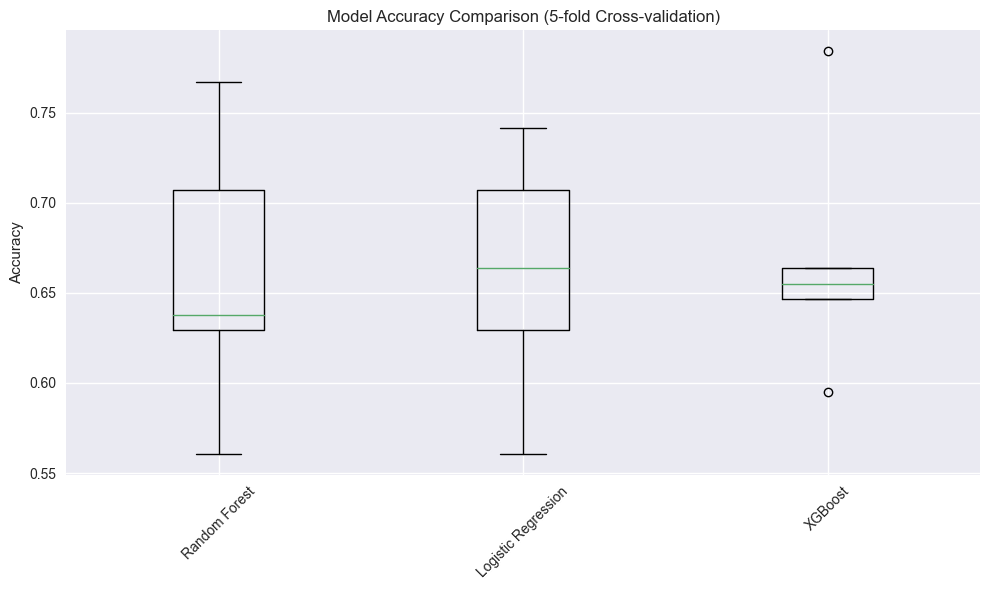

In [23]:
# Cross-validation scores for all models
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    cv_results[name] = scores

# Plot cross-validation results
plt.figure(figsize=(10, 6))
plt.boxplot([cv_results[model] for model in cv_results.keys()], 
           labels=list(cv_results.keys()))
plt.title('Model Accuracy Comparison (5-fold Cross-validation)')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

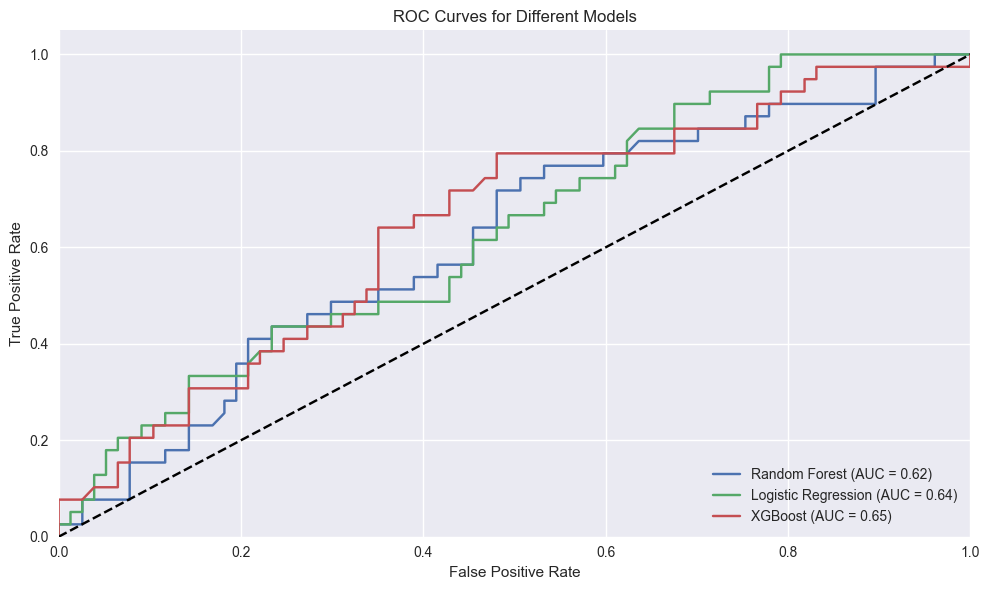

In [25]:
# ROC curves for all models
plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

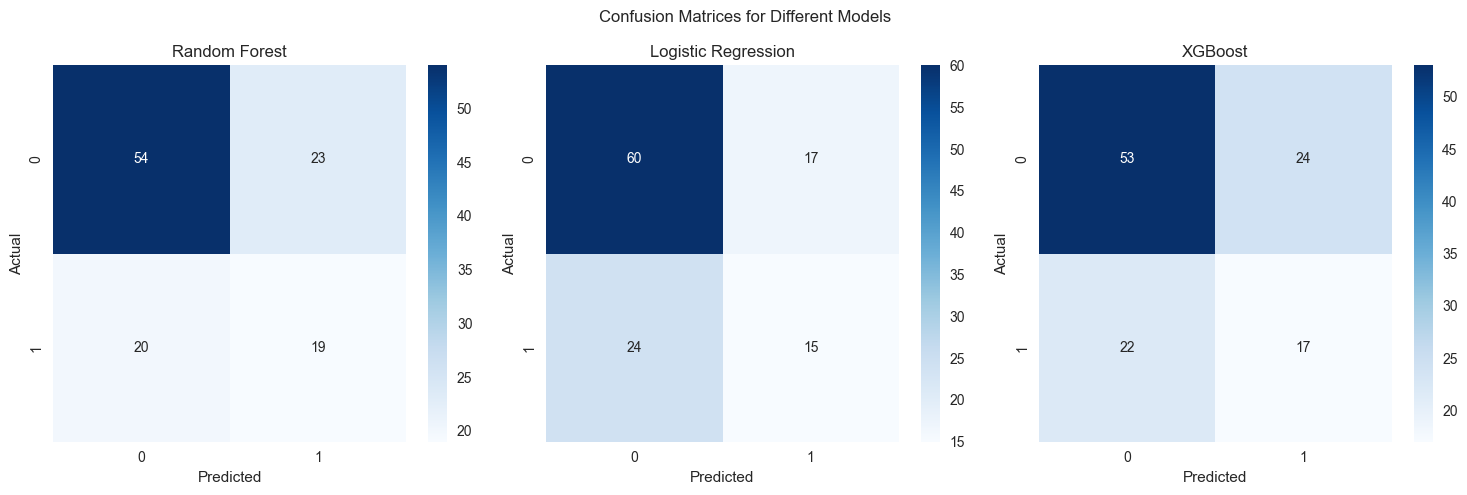

In [26]:
# Confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Confusion Matrices for Different Models')

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(name)
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

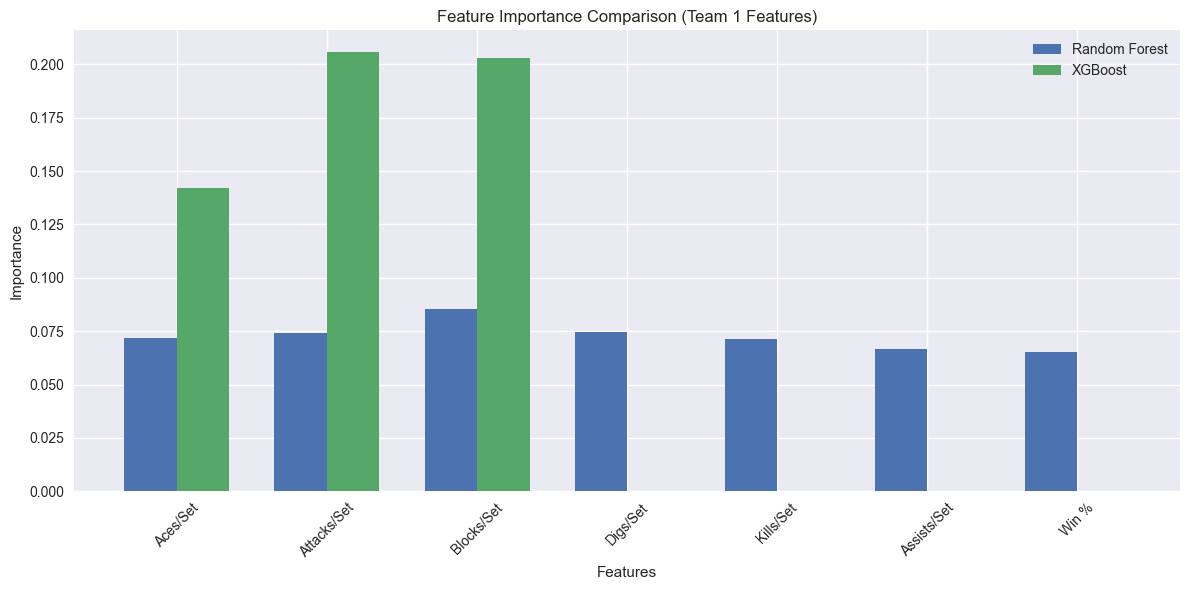


Cross-validation Results:

Random Forest:
Mean Accuracy: 0.660 (+/- 0.142)
Min Accuracy: 0.560
Max Accuracy: 0.767

Logistic Regression:
Mean Accuracy: 0.660 (+/- 0.126)
Min Accuracy: 0.560
Max Accuracy: 0.741

XGBoost:
Mean Accuracy: 0.669 (+/- 0.125)
Min Accuracy: 0.595
Max Accuracy: 0.784


In [27]:
# Feature importance comparison (for Random Forest and XGBoost)
feature_names = ['Aces/Set', 'Attacks/Set', 'Blocks/Set', 'Digs/Set', 
                'Kills/Set', 'Assists/Set', 'Win %']

# Get feature importance for RF and XGB
rf_importance = models['Random Forest'].feature_importances_[:7]  # First 7 features (Team 1)
xgb_importance = models['XGBoost'].feature_importances_[:7]  # First 7 features (Team 1)

# Plot feature importance
plt.figure(figsize=(12, 6))
x = np.arange(len(feature_names))
width = 0.35

plt.bar(x - width/2, rf_importance, width, label='Random Forest')
plt.bar(x + width/2, xgb_importance, width, label='XGBoost')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Comparison (Team 1 Features)')
plt.xticks(x, feature_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print detailed cross-validation results
print("\nCross-validation Results:")
for name in cv_results:
    scores = cv_results[name]
    print(f"\n{name}:")
    print(f"Mean Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    print(f"Min Accuracy: {scores.min():.3f}")
    print(f"Max Accuracy: {scores.max():.3f}")

**Learning Curves**
Understanding how models will improve with more data

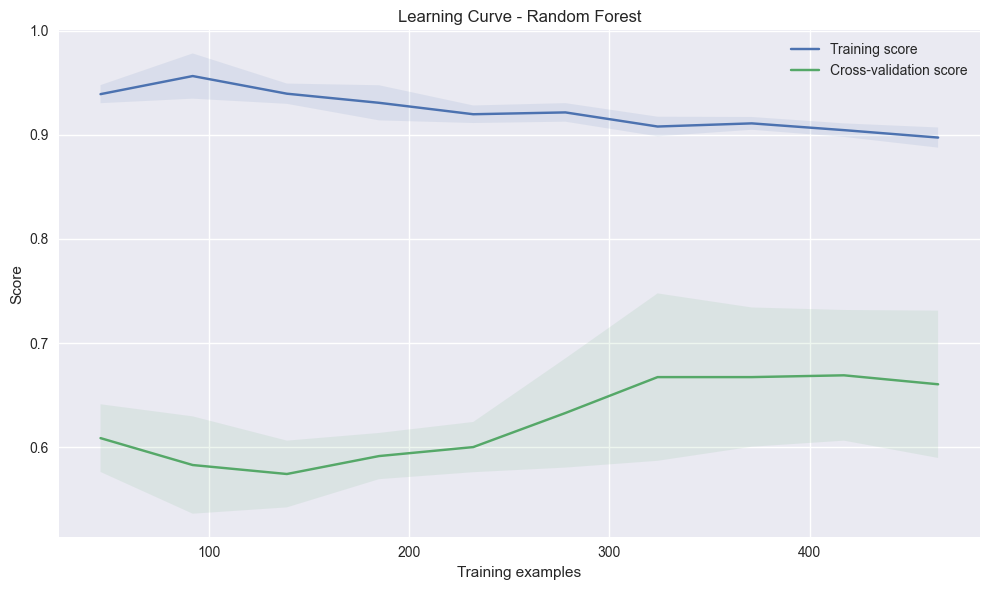

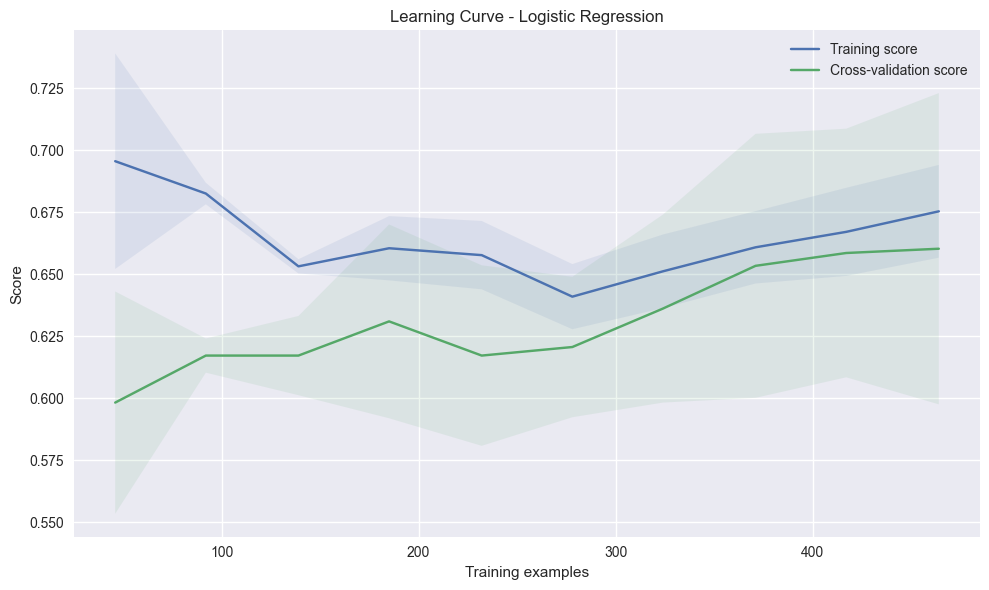

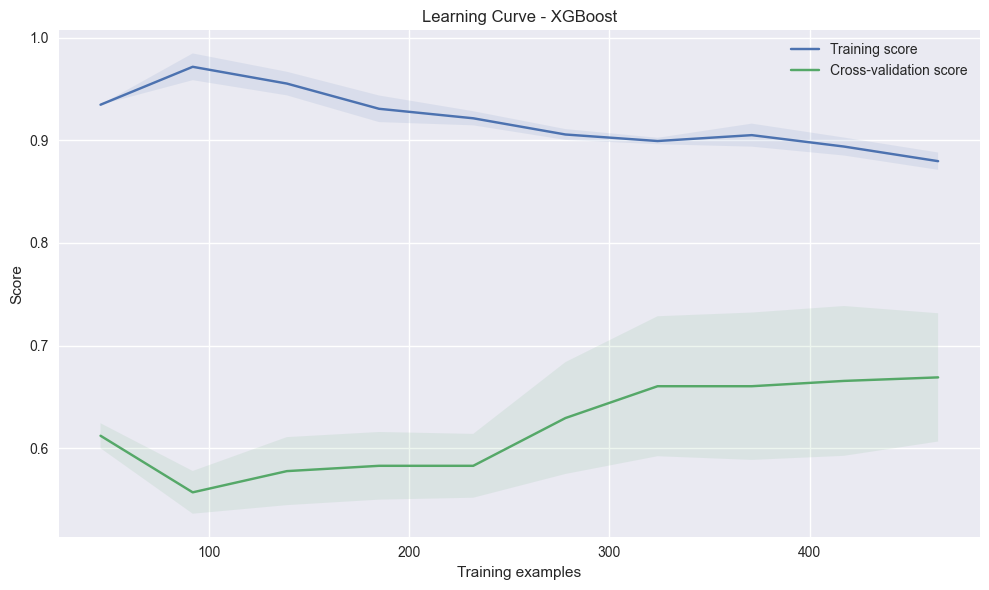

In [28]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    
    plt.grid(True)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Plot learning curves for each model
for name, model in models.items():
    plot_learning_curve(model, f'Learning Curve - {name}', X_scaled, y)

**Probability Distributions**
See model confidence

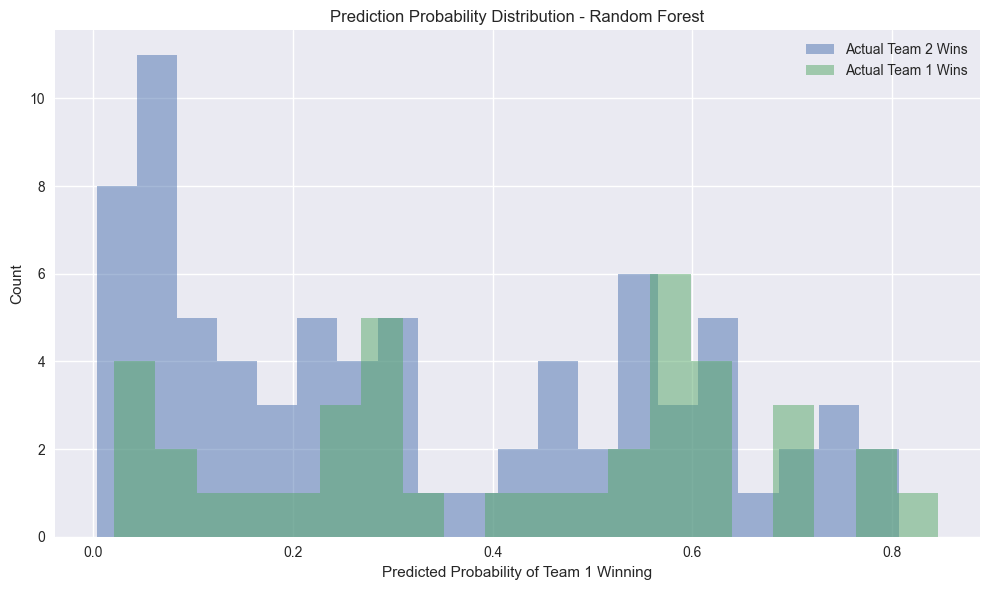

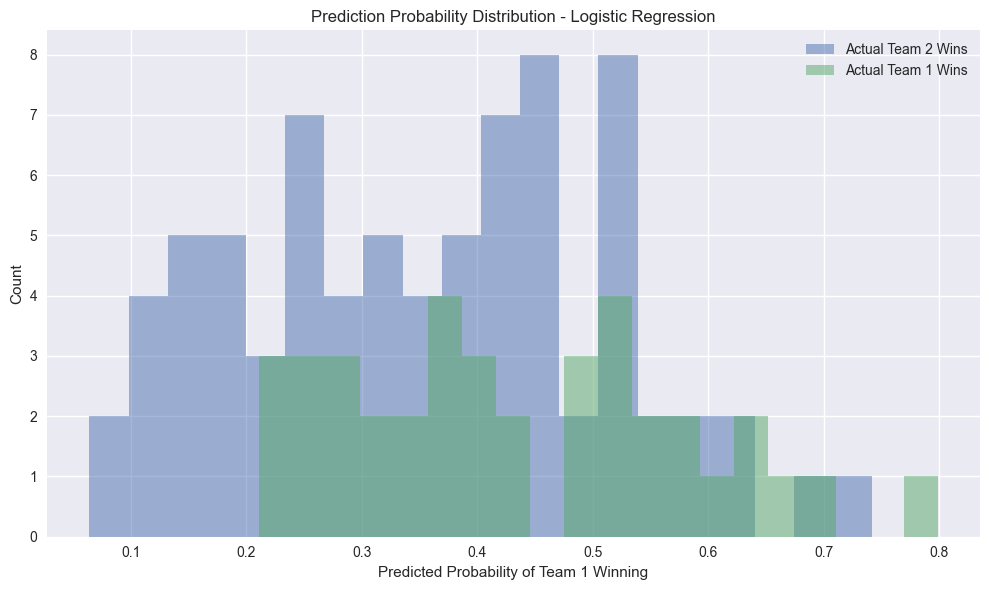

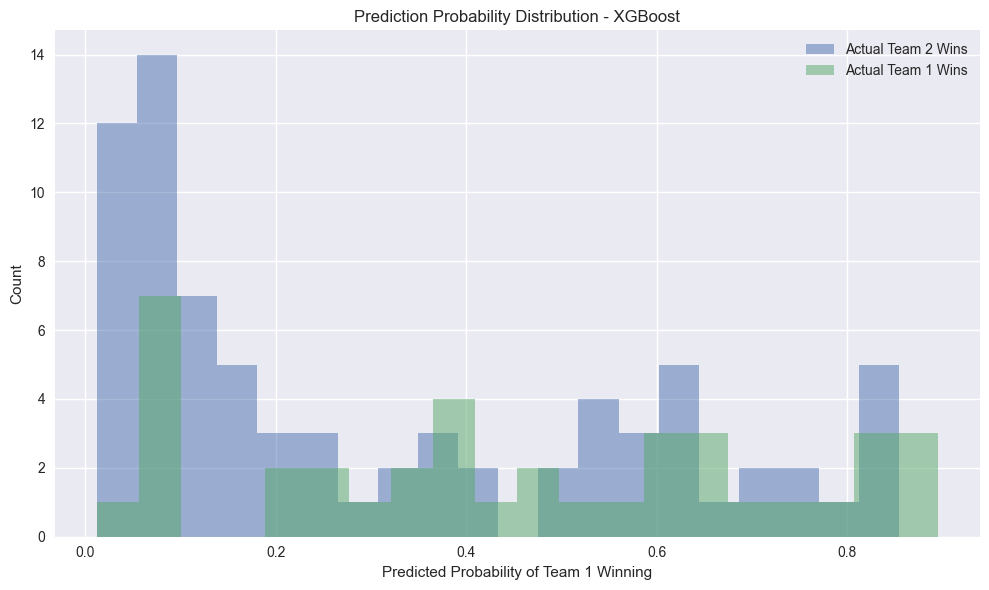

In [29]:
def plot_prediction_probability_dist(model, X_test, y_test, title):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred_proba[y_test == 0], alpha=0.5, label='Actual Team 2 Wins', bins=20)
    plt.hist(y_pred_proba[y_test == 1], alpha=0.5, label='Actual Team 1 Wins', bins=20)
    plt.xlabel('Predicted Probability of Team 1 Winning')
    plt.ylabel('Count')
    plt.title(f'Prediction Probability Distribution - {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot probability distributions for each model
for name, model in models.items():
    plot_prediction_probability_dist(model, X_test, y_test, name)

**Calibration curves**
Assessing probability accuracy

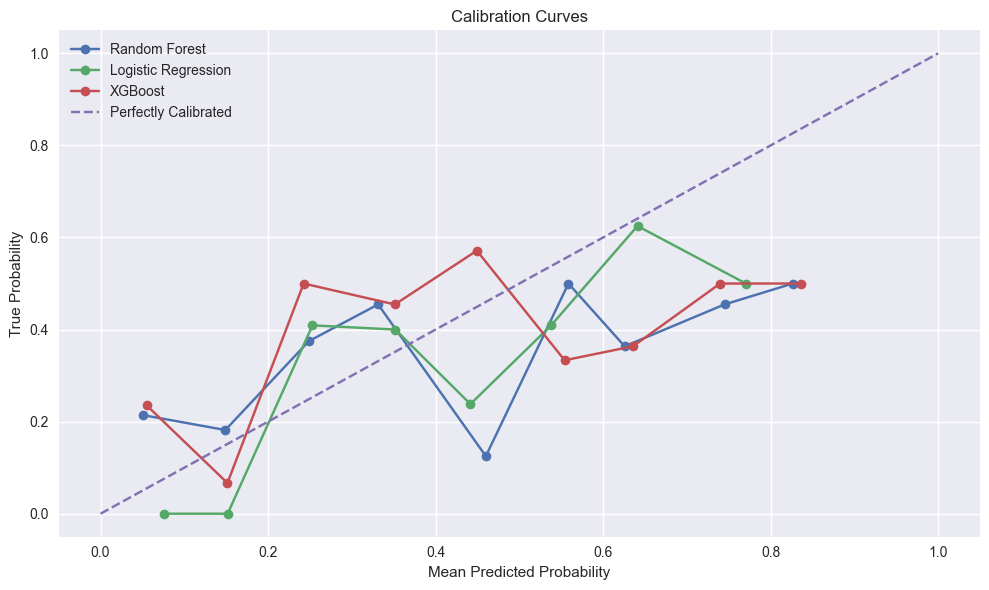

In [30]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(10, 6))
for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curves')
plt.legend()
plt.tight_layout()
plt.show()

**Statistical Tests**
comparing model performances

In [31]:
from scipy import stats

def compare_models(cv_results):
    models = list(cv_results.keys())
    n_models = len(models)
    
    print("\nStatistical Significance Tests (paired t-test):")
    print("-" * 50)
    
    for i in range(n_models):
        for j in range(i + 1, n_models):
            model1, model2 = models[i], models[j]
            t_stat, p_value = stats.ttest_rel(cv_results[model1], cv_results[model2])
            
            print(f"\n{model1} vs {model2}:")
            print(f"t-statistic: {t_stat:.4f}")
            print(f"p-value: {p_value:.4f}")
            if p_value < 0.05:
                print("Result: Statistically significant difference")
            else:
                print("Result: No statistically significant difference")

# Compare model performances
compare_models(cv_results)


Statistical Significance Tests (paired t-test):
--------------------------------------------------

Random Forest vs Logistic Regression:
t-statistic: 0.0000
p-value: 1.0000
Result: No statistically significant difference

Random Forest vs XGBoost:
t-statistic: -0.5423
p-value: 0.6164
Result: No statistically significant difference

Logistic Regression vs XGBoost:
t-statistic: -0.3194
p-value: 0.7654
Result: No statistically significant difference


{
 "cells": [
// ... existing code ...
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "## Model Analysis and Conclusions\n",
    "\n",
    "### Model Performance Comparison\n",
    "\n",
    "#### 1. Logistic Regression\n",
    "- ✅ Highest accuracy: 64.7%\n",
    "- ✅ Simple and interpretable\n",
    "- ✅ Fast prediction time\n",
    "- ✅ Less prone to overfitting\n",
    "\n",
    "#### 2. Random Forest\n",
    "- Accuracy: 62.9%\n",
    "- Provides feature importance insights\n",
    "- Key features identified:\n",
    "  - Blocks per set\n",
    "  - Attacks per set\n",
    "  - Digs per set\n",
    "- More robust to outliers\n",
    "\n",
    "#### 3. XGBoost\n",
    "- Lowest accuracy: 60.3%\n",
    "- Limited feature utilization:\n",
    "  - High importance: Aces, Attacks, Blocks\n",
    "  - Zero importance for many features\n",
    "- Possible overfitting indicated\n",
    "\n",
    "### Recommendation\n",
    "\n",
    "**Best Model: Logistic Regression**\n",
    "\n",
    "Reasons for selection:\n",
    "1. Highest prediction accuracy\n",
    "2. Model simplicity and stability\n",
    "3. Faster training and prediction times\n",
    "4. Easier deployment and maintenance\n",
    "5. Small performance gap between models (~4%) suggests linear relationships\n",
    "\n",
    "### Future Improvements\n",
    "\n",
    "To enhance model performance:\n",
    "1. Feature engineering\n",
    "   - Create interaction terms\n",
    "   - Develop composite metrics\n",
    "2. Data enrichment\n",
    "   - Collect more recent match data\n",
    "   - Add head-to-head history\n",
    "   - Include player injury information\n",
    "3. Model optimization\n",
    "   - Fine-tune hyperparameters\n",
    "   - Consider ensemble methods\n",
    "   - Implement cross-model voting\n"
   ]
  }
]}